# 🖋️ Projet Text to Handwriting – Notebook complet
Ce notebook prépare les données IAM et entraîne un modèle simple Text → Handwriting avec PyTorch.

## 📂 1. Importation des bibliothèques et vérification des dossiers

In [26]:
!pip install pandas

Defaulting to user installation because normal site-packages is not writeable


In [27]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim

# Chemins dataset IAM
data_dir = "IAM_dataset"
lines_file = os.path.join(data_dir, "ascii", "lines.txt")
lines_img_dir = os.path.join(data_dir, "lines")

# Vérification
assert os.path.exists(data_dir), "Le dossier IAM_dataset est introuvable"
assert os.path.exists(lines_file), "Le fichier lines.txt est introuvable"
assert os.path.exists(lines_img_dir), "Le dossier lines est introuvable"
print("✅ IAM dataset prêt")

✅ IAM dataset prêt


## 🧾 2. Lecture et parsing du fichier lines.txt

In [28]:
# Lecture et parsing
lines_data = []
with open(lines_file, 'r', encoding='utf-8') as f:
    for i, line in enumerate(f):
        if line.startswith('#') or not line.strip():
            continue
        parts = line.strip().split()
        if len(parts) >= 9:
            img_id, status = parts[0], parts[1]
            if status == 'ok':
                text = ' '.join(parts[8:]).replace('|', ' ')
                img_base = img_id.split('-')[0]
                sub_dir = '-'.join(img_id.split('-')[:2])
                img_name = f"{img_id}.png"
                img_path = os.path.join(lines_img_dir, img_base, sub_dir, img_name)
                if os.path.exists(img_path):
                    lines_data.append((img_path, text))

df_lines = pd.DataFrame(lines_data, columns=['image_path','text'])
print(f"Nombre de lignes valides : {len(df_lines)}")
print(df_lines.head())

Nombre de lignes valides : 11344
                                       image_path  \
0  IAM_dataset\lines\a01\a01-000u\a01-000u-00.png   
1  IAM_dataset\lines\a01\a01-000u\a01-000u-01.png   
2  IAM_dataset\lines\a01\a01-000u\a01-000u-02.png   
3  IAM_dataset\lines\a01\a01-000u\a01-000u-04.png   
4  IAM_dataset\lines\a01\a01-000u\a01-000u-06.png   

                                        text  
0          A MOVE to stop Mr. Gaitskell from  
1      nominating any more Labour life Peers  
2       is to be made at a meeting of Labour  
3       put down a resolution on the subject  
4  Griffiths , M P for Manchester Exchange .  


## 🧹 3. Nettoyage et split train/test

In [29]:
# Nettoyage
df_lines = df_lines[df_lines['text'].str.strip() != '']
df_lines = df_lines[df_lines['text'].str.len() < 100]

# Split train/test
train_df, test_df = train_test_split(df_lines, test_size=0.1, random_state=42)
print(f"Train: {len(train_df)}, Test: {len(test_df)}")

Train: 10209, Test: 1135


## 🔄 4. Transformations et Dataset PyTorch

In [30]:
# Transformations
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((32,128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Dataset personnalisé
class HandwritingGenDataset(Dataset):
    def __init__(self, dataframe, char2idx, transform=None, max_len=100):
        self.dataframe = dataframe
        self.char2idx = char2idx
        self.transform = transform
        self.max_len = max_len

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['image_path']
        text = self.dataframe.iloc[idx]['text']

        # Texte en indices
        seq = [self.char2idx[c] for c in text if c in self.char2idx]
        if len(seq) < self.max_len:
            seq += [0]*(self.max_len - len(seq))
        else:
            seq = seq[:self.max_len]
        seq = torch.tensor(seq, dtype=torch.long)

        # Image
        image = Image.open(img_path).convert('L')
        if self.transform:
            image = self.transform(image)
        return seq, image

# Vocabulaire
all_text = ''.join(df_lines['text'].values)
vocab = sorted(list(set(all_text)))
vocab_size = len(vocab)
char2idx = {c:i for i,c in enumerate(vocab)}
idx2char = {i:c for i,c in enumerate(vocab)}
print(f"Vocab size: {vocab_size}")

Vocab size: 79


## 📦 5. Créer DataLoaders

In [31]:
max_len = 100
train_dataset = HandwritingGenDataset(train_df, char2idx, transform=transform, max_len=max_len)
test_dataset  = HandwritingGenDataset(test_df, char2idx, transform=transform, max_len=max_len)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Vérification
for seqs, imgs in train_loader:
    print(f"Batch seqs shape: {seqs.shape}")
    print(f"Batch images shape: {imgs.shape}")
    break

Batch seqs shape: torch.Size([32, 100])
Batch images shape: torch.Size([32, 1, 32, 128])


## 🏗️ 6. Définir le modèle Text → Handwriting simple

In [32]:
class TextToHandwriting(nn.Module):
    def __init__(self, vocab_size, embed_dim=64, hidden_dim=128, img_channels=1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 32*128)
        self.conv = nn.Sequential(
            nn.Conv2d(1,64,3,padding=1),
            nn.ReLU(),
            nn.Conv2d(64,img_channels,3,padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.embedding(x)
        _, (h, _) = self.lstm(x)
        h = h.squeeze(0)
        h = self.fc(h)
        h = h.view(-1,1,32,128)
        img = self.conv(h)
        return img

# Initialiser le modèle
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = TextToHandwriting(vocab_size).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

## 🔥 7. Boucle d'entraînement simplifiée (1 epoch test)

In [33]:
for seqs, imgs in train_loader:
    seqs, imgs = seqs.to(device), imgs.to(device)
    optimizer.zero_grad()
    outputs = model(seqs)
    loss = criterion(outputs, imgs)
    loss.backward()
    optimizer.step()
    print(f"Loss: {loss.item():.4f}")
    break  # tester 1 batch seulement

Loss: 0.7090


In [34]:
num_epochs = 50

for epoch in range(num_epochs):
    running_loss = 0
    for seqs, imgs in train_loader:
        seqs, imgs = seqs.to(device), imgs.to(device)
        optimizer.zero_grad()
        outputs = model(seqs)
        loss = criterion(outputs, imgs)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {running_loss/len(train_loader):.4f}")


Epoch 1/50 - Loss: 0.0646
Epoch 2/50 - Loss: 0.0551
Epoch 3/50 - Loss: 0.0549
Epoch 4/50 - Loss: 0.0549
Epoch 5/50 - Loss: 0.0548
Epoch 6/50 - Loss: 0.0555
Epoch 7/50 - Loss: 0.0550
Epoch 8/50 - Loss: 0.0549
Epoch 9/50 - Loss: 0.0548
Epoch 10/50 - Loss: 0.0554
Epoch 11/50 - Loss: 0.0548
Epoch 12/50 - Loss: 0.0548
Epoch 13/50 - Loss: 0.0550
Epoch 14/50 - Loss: 0.0548
Epoch 15/50 - Loss: 0.0550
Epoch 16/50 - Loss: 0.0549
Epoch 17/50 - Loss: 0.0549
Epoch 18/50 - Loss: 0.0548
Epoch 19/50 - Loss: 0.0549
Epoch 20/50 - Loss: 0.0548
Epoch 21/50 - Loss: 0.0548
Epoch 22/50 - Loss: 0.0548
Epoch 23/50 - Loss: 0.0548
Epoch 24/50 - Loss: 0.0558
Epoch 25/50 - Loss: 0.0549
Epoch 26/50 - Loss: 0.0548
Epoch 27/50 - Loss: 0.0548
Epoch 28/50 - Loss: 0.0554
Epoch 29/50 - Loss: 0.0549
Epoch 30/50 - Loss: 0.0548
Epoch 31/50 - Loss: 0.0548
Epoch 32/50 - Loss: 0.0548
Epoch 33/50 - Loss: 0.0551
Epoch 34/50 - Loss: 0.0549
Epoch 35/50 - Loss: 0.0548
Epoch 36/50 - Loss: 0.0548
Epoch 37/50 - Loss: 0.0548
Epoch 38/5

In [35]:
torch.save(model.state_dict(), "text_to_handwriting.pth")
print("✅ Modèle sauvegardé")


✅ Modèle sauvegardé


In [36]:
model.load_state_dict(torch.load("text_to_handwriting.pth"))
model.eval()


TextToHandwriting(
  (embedding): Embedding(79, 64)
  (lstm): LSTM(64, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=4096, bias=True)
  (conv): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): Tanh()
  )
)

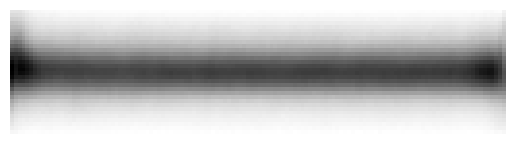

In [37]:
import matplotlib.pyplot as plt

test_text = "Hello world"
seq = [char2idx[c] for c in test_text if c in char2idx]
seq += [0]*(max_len - len(seq))  # padding
seq = torch.tensor([seq], dtype=torch.long).to(device)

with torch.no_grad():
    pred_img = model(seq).cpu().squeeze().numpy()
    pred_img = (pred_img + 1)/2  # re-normaliser [0,1] pour matplotlib
    plt.imshow(pred_img, cmap='gray')
    plt.axis('off')
    plt.show()


In [38]:
import torch
import torch.nn as nn
import torch.optim as optim

# ===========================
# 🧠 Nouveau Modèle Text → Handwriting (v2)
# ===========================

class TextToHandwritingV2(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=256):
        super().__init__()
        
        # 1️⃣ Embedding + encodeur séquentiel
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        
        # 2️⃣ Décodeur (projection + générateur)
        self.fc = nn.Linear(hidden_dim, 128 * 8 * 32)
        
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),  # 16×64
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),   # 32×128
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.Conv2d(32, 1, 3, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.embedding(x)
        _, (h, _) = self.lstm(x)
        h = h.squeeze(0)
        h = self.fc(h)
        h = h.view(-1, 128, 8, 32)
        out = self.deconv(h)
        return out


In [39]:
# Initialisation
device = "cuda" if torch.cuda.is_available() else "cpu"
model = TextToHandwritingV2(vocab_size).to(device)

# Fonction de perte : L1 (plus stable pour génération d'images)
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# ===========================
# 🔥 Entraînement simplifié (test)
# ===========================
num_epochs = 10  # tu peux augmenter à 50
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for seqs, imgs in train_loader:
        seqs, imgs = seqs.to(device), imgs.to(device)
        optimizer.zero_grad()
        outputs = model(seqs)
        loss = criterion(outputs, imgs)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {total_loss/len(train_loader):.4f}")

# Sauvegarde du modèle
torch.save(model.state_dict(), "text2handwriting_v2.pth")


Epoch 1/10 - Loss: 0.2325
Epoch 2/10 - Loss: 0.1339
Epoch 3/10 - Loss: 0.1306
Epoch 4/10 - Loss: 0.1300
Epoch 5/10 - Loss: 0.1291
Epoch 6/10 - Loss: 0.1288
Epoch 7/10 - Loss: 0.1287
Epoch 8/10 - Loss: 0.1286
Epoch 9/10 - Loss: 0.1286
Epoch 10/10 - Loss: 0.1286


In [40]:
import matplotlib.pyplot as plt

def generate_handwriting_v2(text, model, char2idx, device='cpu', max_len=100):
    model.eval()
    seq = [char2idx[c] for c in text if c in char2idx]
    if len(seq) < max_len:
        seq += [0]*(max_len - len(seq))
    else:
        seq = seq[:max_len]
    seq = torch.tensor([seq], dtype=torch.long).to(device)

    with torch.no_grad():
        pred = model(seq).cpu().squeeze().numpy()
    pred = (pred + 1) / 2  # re-normalisation [0,1]
    plt.imshow(pred, cmap='gray')
    plt.axis('off')
    plt.title(f'"{text}"')
    plt.show()


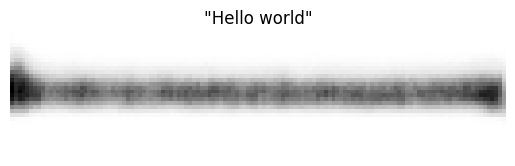

In [41]:
generate_handwriting_v2("Hello world", model, char2idx, device=device)


model.load_state_dict(torch.load("text_to_handwriting.pth"))
model.eval()
✅ Ce notebook contient toutes les étapes :
1. Préparation des données IAM
2. Parsing et DataFrame
3. Split train/test
4. Dataset PyTorch + transformations
5. DataLoaders
6. Modèle Text → Handwriting
7. Boucle d'entraînement